#  Monte Carlo Simulation (Advanced)

이번 강의에는 지난 강의에서 언급된 GBM을 이용한 파생상품 평가 방법론인 몬테카를로 시뮬레이션을 설명합니다.

## 1. 몬테카를로 시뮬레이션의 정의

몬테카를로 시뮬레이션이란, 통계학에서 사용되는 큰 수의 법칙을 금융에 이용한 것입니다.
파생상품뿐만이 아닌 모든 자산의 가격은 다음 식을 만족합니다.

$$ P_t = e^{-r(T-t)}E(CF_T) $$

이때 $P_t$는 자산의 현재 가격, $CF_T$는 만기 시점에서의 현금흐름입니다. 또 $t$는 현재 시점을, $T$는 만기 시점을 나타냅니다 <br>
즉, 만기 시점에서의 현금흐름의 기댓값을 현재가치화한 것이 자산의 가격입니다.<br>
하지만 현금흐름의 기댓값을 수학적으로 구하기 어렵다는 것이 가격결정의 가장 큰 문제점입니다.<br>
몬테카를로 시뮬레이션은 이 문제를 큰 수의 법칙을 이용해 해결합니다.
큰 수의 법칙은 다음과 같습니다

If $N$ is big,
$$ E(X) \approx {{(X_1 + X_2 + X_3 + ...+ X_N)}\over N} $$

몬테카를로 시뮬레이션은 이를 이용해, 현재 알고 있는 주가의 분포를 활용해 가능한 주가 시나리오를 최대한 많이 제작하여,<br> 만기 시점에서의 현금흐름의 평균을 구해 현재가치화하는 방법으로 금융상품의 적정가치를 계산합니다.

## 2. 기본적인 몬테카를로 시뮬레이션

이제 지난 강의에서 언급된 GBM과 바닐라 옵션의 payoff를 이용해 주가가 로그 정규분포를 따를 때의 바닐라 콜옵션의 가격을 구해 보겠습니다.

GBM을 따르는 주가는 다음 확률과정을 따릅니다.<br>
$$ {dS \over S}  = rdt + \sigma dW $$
이때 $r$은 무위험이자율, $\sigma$는 주가의 $dt$시간 동안의 변동성, $dW$는 표준정규분포를 따르는 확률변수입니다. <br>
즉 이 식에서 시나리오를 제작해야 하는 불확실한 과정, 즉 확률과정은 $dW$ 뿐이므로, $dW$의 시나리오를 제작하여 위 식에 대입하면 주가의 시나리오를 제작할 수 있습니다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy
from scipy.stats import norm

In [2]:
N = norm.cdf
def CallOptionBS(S, K, T, r, q, sigma):
    if T == 0.0:
        return np.maximum(S - K, 0)
    else:
        d1 = (np.log(S / K) + (r - q + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * np.exp(-q * T) * N(d1) - K * np.exp(-r * T) * N(d2)

def relative(S1,S2,X,T,r,q1,q2,sigma1,sigma2,rho):
    if T==0.0:
        return np.maximum((S1/S2)-X,0)
    else:
        F = (S1/S2)*np.exp((q1-q2+sigma2**2-rho*sigma1*sigma2)*T)
        sigma = np.sqrt(sigma1**2+sigma2**2-2*rho*sigma1*sigma2)
        d1 = (np.log(F/X)+0.5*T*sigma**2)/(sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        return np.exp(-r*T)*(F*N(d2)-X*N(d1))

시작 가정으로 현재 주가는 100, 연속 배당률은 0, 연속 무위험 이자율은 2%, 주가의 변동성은 20%, 만기는 1년이며, 이는 250일의 영업일로 이루어진 것으로 가정합니다. 그리고 시뮬레이션의 횟수는 10000번으로 설정합니다.

In [3]:
s0 = 100
q = 0
r = 0.02
sigma = 0.2
T = 1
days = 250
nsimulation = 10000

그러면 표준 정규분포의 시나리오는 250일간의 시나리오가 총 10000번 제작되니 총합 250만 개 제작됩니다.<br>
편의를 위해 250×10000 행렬로 제작하겠습니다.

In [4]:
Normal = np.random.normal(size=(T*days, nsimulation))

주가가 250일동안 변하니 주가의 시나리오는 시작일을 포함해 총 251일간의 시나리오가 됩니다.

In [5]:
path = np.zeros((T*days+1,nsimulation))
path[0] = s0

변화한 주가 $S+ds$는 다음과 같습니다<br>
$$S+ds = S(1+{dS\over S}) = S(1+rdt+\sigma_{dt} dW)$$
이때 $\sigma_{dt}$는 짧은 시간 $dt$동안의 주가의 변동성으로 1년동안의 주가의 변동성 $\sigma$와 다음의 관계를 가집니다.<br>
$$\sigma_{dt} = \sigma \sqrt {dt}$$
이제 $dW$ 시나리오를 토대로 $rdt+\sigma_{dt} dW$ 시나리오를 만듭니다

In [6]:
dt = 1/250
logds = r*dt + Normal * sigma*np.sqrt(dt)

이제 만든 시나리오를 이용해 주가 시나리오를 완성합니다

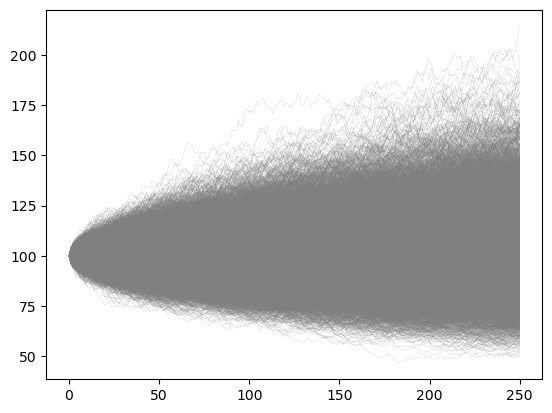

In [7]:
for i in range(1,T*days+1):
    path[i] = path[i-1]*(1+logds[i-1])
plt.plot(path,color = "gray",linewidth = "0.1")
plt.show()

이제 콜옵션의 행사가격 $K$를 100으로 지정하고, 콜옵션의 payoff인 $max(S-K,0)$를 각 시나리오의 만기에 적용시켜 평균을 구하고 현재가치로 할인하여 콜옵션의 적정가격을 구할 수 있습니다

In [8]:
np.mean(np.maximum(path[-1]-100,0))*np.exp(-r*T)

8.83907026612256

수학적으로 계산한 콜옵션 가격과 비교했을 때, 높은 정확도를 보이는 것을 알 수 있습니다.

In [9]:
CallOptionBS(s0, 100, T, r, q, sigma)

8.916037278572539

## 3. 심화 몬테카를로 시뮬레이션

위의 방법으로 기초자산이 1개인 파생상품의 가격은 쉽게 구할 수 있지만, 현재 발행되는 ELS는 대부분 2개 이상의 기초자산을 가집니다.<br>
따라서 기초자산이 2개 이상이고, 각 기초자산의 상관관계가 존재하는 경우의 파생상품의 가격결정을 실행해 보겠습니다. <br>
즉 자산 $S_1$과 $S_2$는 다음과 같은 확률과정을 따른다고 가정합니다.
$$ {dS_1 \over S_1}  = rdt + \sigma_1 dW_1 $$ <br>
$$ {dS_2 \over S_2}  = rdt + \sigma_2 dW_2 $$ <br>
$$dW_1dW_2 = \rho dt $$
이때, $\rho$ 는 각 확률변수의 상관계수이며,$\sigma_1$, $\sigma_2$는 각각 첫 번째 기초자산과 두 번째 기초자산의 변동성,<br> 세 번째 식은 $cov(dW_1,dW_2) = \rho $를 의미합니다.

###  상관관계가 존재하는 확률변수 만들기

일단 위에서 실행했던 것처럼 확률변수를 두 개 만들겠습니다.

In [10]:
nsimulation = 10000
Normal1 = np.random.normal(size=(T*days, nsimulation))
Normal2 = np.random.normal(size=(T*days, nsimulation))

In [11]:
nor1 = Normal1.reshape(1,T*days*nsimulation)
nor2 = Normal2.reshape(1,T*days*nsimulation)

하지만 이렇게 만든 난수는 상관관계가 거의 없는 것을 볼 수 있습니다

In [12]:
np.corrcoef(nor1,nor2)[0,1]

0.00014172277292893423

상관관계가 있는 난수를 만들기 위해서 촐레스키 분해를 사용합니다<br>
촐레스키 분해를 통해 상관계수 행렬은 다음과 같이 분해됩니다<br>
$$\Omega = \begin{bmatrix} 1 & \rho \\ \rho & 1 \end{bmatrix}	 = \begin{bmatrix} 1 & 0 \\ \rho &\sqrt{1-\rho^2}  \end{bmatrix}	\begin{bmatrix} 1 & \rho \\ 0 &\sqrt{1-\rho^2}  \end{bmatrix} = LL^T	$$
그리고 $L$을 곱한 난수행렬을 다음과 같이 정의하면 새로운 두 난수는 $\rho$의 상관계수를 가지는 난수가 됩니다<br>
$$\begin{bmatrix} Z_1 \ \\ Z_2 \end{bmatrix} = L \begin{bmatrix} W_1 \ \\ W_2 \end{bmatrix}$$ 
이제 해당 계산을 통해 기존의 난수를 상관관계가 존재하는 난수로 바꿔줍니다

In [13]:
rho = 0.7
nor2 = rho*nor1 + np.sqrt(1-rho**2)*nor2

두 난수는 $\rho$의 상관관계를 가지고 있음을 알 수 있습니다

In [14]:
np.corrcoef(nor1,nor2)[0,1]

0.7002691141011984

이제 만든 $dW$ 시나리오를 이용하여 $S_1$과 $S_2$ 시나리오를 제작합니다. <br>
편의를 위해 두 자산의 현재가격과 배당률, 변동성이 이전 챕터에서의 자산과 동일하다고 가정합니다.

In [15]:
Normal1 = nor1.reshape(T*days,nsimulation)
Normal2 = nor2.reshape(T*days,nsimulation)

dt = 1/250
logds1 = r*dt + Normal1 * sigma*np.sqrt(dt)
logds2 = r*dt + Normal2 * sigma*np.sqrt(dt)

path1 = np.zeros((T*days+1,nsimulation))
path2 = np.zeros((T*days+1,nsimulation))
path1[0] = s0
path2[0] = s0

for i in range(1,T*days+1):
    path1[i] = path1[i-1]*(1+logds1[i-1])
    path2[i] = path2[i-1]*(1+logds2[i-1])

이제 만든 주가패스를 이용해 $max({S_1\over S_2}-X , 0)$ 를 payoff로 가지는 교환옵션의 가격을 구합니다. <br>
이때 $X = 0.5$로 설정합니다.

In [16]:
X = 0.5
path3 = path1/path2
np.mean(np.maximum(path3[-1]-0.5,0))*np.exp(-r*T)

0.5029572193009236

이렇게 구한 가격도 Closed Form Solution과 비슷한 값을 가지는 것을 볼 수 있습니다.

In [17]:
relative(s0,s0,X,T,r,0,0,sigma,sigma,rho)

0.5019296743420033